$\large Logica \  Computacional\ 02-Outubro-2023 \ LCC$

$\textbf{Grupo 06:}$

* João Manuel Franqueira da Silva, A91638
* Eduardo Manuel Sousa Pereira, A70619


$\huge TP1 - Problema\ 1 $

Pretende-se construir o horário semanal de aulas de uma turma.
1. Existe um conjunto de salas S classificadas em “grandes” e “pequenas”.
2. O tempo do horário está organizado em “slots” de uma hora. O total do tempo disponível é 5 horas de manhã e 5 horas de tarde. 
3. Existe um conjunto $\textit{D}$ de disciplinas.  Cada disciplina tem um atributo $d \in \{1,2\}$ que classifica a duração de cada sessão (um ou dois “slots”) , um atributo $a \in \{2,3\}$ que define o número de sessões semanais e um atributo $s \in \{0,1\}$ que diz se a sessão necessita de uma sala grande ou não.
4. Existe um conjunto $\textit{P}$ de professores. Cada professor tem associado um conjunto  $\textit{h}$ das disciplinas que está habilitado a lecionar.
5. O horário está organizado em sessões concorrentes onde cada sessão é definido por uma disciplina desce que salas e professores verifiquem as seguintes restrições:

    i. Para cada disciplina todas as aulas decorrem na mesma sala e com o mesmo professor.
    
    ii. O número total de horas lecionadas por cada professor está num intervalo de $\textit{+/- 20%}$ do número médio de horas lecionadas pela totalidade dos professores.
    
    iii. Nenhuma sala pode ser ocupada simultaneamente por mais do que uma aula e nenhum professor pode lecionar simultaneamente mais do que uma aula.
    
    iv. Em cada disciplina, cada aula é lecionada por um professor habilitado para essa disciplina e ocorre numa sala de tamanho apropriado à disciplina.

In [1356]:
from ortools.linear_solver import pywraplp
import random
from pysmt.shortcuts import Symbol, LE, GE, Int, And, Equals, Plus, Solver, LE, Not, Or, And, GT, is_sat
from pysmt.typing import INT

${\LARGE\text{Variáveis}}$

* $\text{num_professores}$ - número de professores disponíveis
* $\text{num_disciplinas}$ - número de disciplinas disponíveis
* $\text{num_salas}$ - número de salas disponíveis
* $\text{P}$ - conjunto dos professores
* $\text{h}$ - disciplinas que cada professor está habilitado a lecionar
* $\text{D}$ - conjunto das disciplinas
* $\text{d}$ - duração de uma aula de cada disciplina
* $\text{a}$ - número de aulas semanais de cada disciplina
* $\text{s}$ - tamanho da sala requerido por cada disciplina
* $\text{S}$ - conjunto das salas e respetivo tamanho
* $\text{disciplina_professor}$ - matriz de atribuição de professores a disciplinas
* $\text{disciplina_sala}$ - matriz de atribuição de salas a disciplinas
* $\text{horario}$ - matriz de alocação de slots de tempo a disciplinas


${\LARGE\text{Definir inputs e inicialização dos solvers}}$

$\text{Optamos pela utilização de dois solvers, pois ao utilizar apenas um, deparamo-nos com um elevado tempo de espera por uma possivel resolução.}$

In [1357]:
#Exemplo 1
#P=[
#    ("Ramos",[1,0,1,0,0,1,0,1,1,1,0,0,0,1]),
#    ("Albertina",[1,1,1,1,1,1,1,1,1,1,1,1,1,1]),
#    ("Paulina",[0,0,1,1,1,0,0,0,1,0,0,1,1,1]),
 #   ("Lara",[1,1,0,0,1,1,1,1,1,0,1,1,0,0]),
#    ("Luisão",[1,1,1,1,1,0,0,0,0,1,1,1,0,1]),
 #   ("David",[1,1,0,1,1,1,1,0,0,1,1,1,1,1]),
#]

#D=[
#    ("Matemática",[1,2,0]),
#    ("Português",[1,3,0]),
 #   ("Inglês",[1,3,0]),
#    ("Francês",[2,3,1]),
#    ("EF",[1,3,0]),
#    ("Química",[1,3,0]),
#    ("Física",[2,3,0]),
#    ("EV",[1,3,0]),
#    ("ET",[2,2,0]),
#    ("EMRC",[2,3,0]),
#    ("História",[1,2,0]),
#    ("Geografia",[2,3,1]),
#    ("Filosofia",[2,3,0]),
#    ("Psicologia",[2,2,1]),
#]



#Exemplo 2
P=[
    ("Tiago",[1,0,0,1,0,1,1,1,1,0,0,1]),
    ("Pedro",[1,1,0,0,0,0,0,0,1,1,1,1]),
    ("Mário",[0,0,1,0,0,0,1,1,1,0,1,0]),
    ("Carla",[1,1,1,1,1,1,1,0,0,1,1,1])
]

D=[
    ("PF",[2,2,1]),
    ("CP",[1,2,0]),
    ("CC",[1,3,0]),
    ("PI",[2,3,1]),
    ("AUC",[2,2,1]),
    ("AEC",[1,2,1]),
    ("Análise",[1,3,0]),
    ("Sistemas",[1,3,1]),
    ("Cálculo",[1,3,1]),
    ("Álgebra",[2,2,0]),
    ("MD",[1,3,1]),
    ("Tópicos",[1,3,0]),
]

h=1  #conjunto das disciplinas que cada professor pode lecionar
num_professores=len(P)

d=0 #duraçao da disciplina
a=1 #num de aulas da disciplina
s=2 #tamanho da sala necessitada
num_disciplinas=len(D)

S=[0,1,1,0]
num_salas=len(S)

solver = pywraplp.Solver.CreateSolver('SCIP')
solver2 = pywraplp.Solver.CreateSolver('SCIP')

${\LARGE\text{Declaração da matriz principal}}$

Depois de inicializar a matriz, temos que garantir que:
* todas as disciplinas têm o numero correcto de horas lecionadas em uma semana.

* As disciplinas com aulas de uma hora, não são lecionadas seguidas umas das outras.

* As disciplinas com aulas de duas horas são lecionadas em dois slots de tempo consecutivos, e não mais que isso.


In [1358]:
horario = {}
for dia in range(5):
    horario[dia] = {}
    for hora in range(10):
        horario[dia][hora] = {}
        for disc in range(num_disciplinas):
            horario[dia][hora][disc] = solver2.BoolVar("horario[%i][%i][%i]" % (dia,hora,disc))
                
                  
for disc in range(num_disciplinas):
    solver2.Add(sum(horario[dia][hora][disc] for dia in range(5) for hora in range(10)) == D[disc][1][d]*D[disc][1][a])
    
#aulas de duas horas são lecionadas aos pares
for disc in range(num_disciplinas):      
    if D[disc][1][d] == 2:     
        for dia in range(5):
            for hora in range(10):
                if hora == 0:
                    solver2.Add(horario[dia][hora][disc] <= horario[dia][hora+1][disc])
                if 0 < hora < 9:
                    solver2.Add(horario[dia][hora][disc] <= horario[dia][hora+1][disc] + horario[dia][hora-1][disc])
                if hora == 9:
                    solver2.Add(horario[dia][hora][disc] <= horario[dia][hora-1][disc])
                                       
#aulas de uma hora nao sao seguidas
for disc in range(num_disciplinas):
    if not D[disc][1][d] == 2:    
            for dia in range(5):
                for hora in range(10):
                    if hora==0:
                        solver2.Add(horario[dia][hora][disc]+horario[dia][hora+1][disc]<=1)
                    if hora==9:
                        solver2.Add(horario[dia][hora][disc]+horario[dia][hora-1][disc]<=1)
                    if hora>0 and hora<9:
                        solver2.Add(horario[dia][hora][disc]+horario[dia][hora+1][disc]<=1)
                        solver2.Add(horario[dia][hora][disc]+horario[dia][hora-1][disc]<=1)
                        
#nao ha 3 ou mais aulas de duas horas seguidas
for dia in range(5):
    for hora in range(10):
        for disc in range(num_disciplinas):
            if horario[dia][hora][disc]==1:
                if D[disc][1][d]==2:
                    if hora>1 and hora<8:
                        solver2.Add(horario[dia][hora][disc]+horario[dia][hora-1][disc]+horario[dia][hora+1][disc]<=2)

* i. Para cada disciplina todas as aulas decorrem na mesma sala e com o mesmo professor.

$\forall_{\text{disc } \in \{0, \ldots,\text{num_disciplinas-1}\}} : \sum_{\text{prof } \in \{0, \ldots, \text{ num_professores-1}\}} \text{disciplina_professor[disc][prof]} = 1$

$\forall_{\text{disc } \in \{0, \ldots,\text{num_disciplinas-1}\}} : \sum_{\text{sala } \in \{0, \ldots, \text{ num_salas-1}\}} \text{ disciplina_sala[disc][sala]} = 1$

In [1359]:
#MATRIZ PARA OS PROFS
disciplina_professor = {}
for disc in range(num_disciplinas):
    disciplina_professor[disc] = {}
    for prof in range(num_professores):
        disciplina_professor[disc][prof] = solver.IntVar(0, 1, "disciplina_professor[%i][%i]" % (disc, prof))
        
#cada cadeira tem um e so um professor
for disc in range(num_disciplinas):
    solver.Add(solver.Sum(disciplina_professor[disc][prof] for prof in range(num_professores))==1)
    
#MATRIZ PARA AS SALAS
disciplina_sala = {}
for disc in range(num_disciplinas):
    disciplina_sala[disc] = {}
    for sala in range(num_salas):
        disciplina_sala[disc][sala] = solver.IntVar(0, 1, "disciplina_sala[%i][%i]" % (disc, sala))
                
#ASSOCIA a uma cadeira uma sala
for disc in range(num_disciplinas):
    solver.Add(solver.Sum(disciplina_sala[disc][sala] for sala in range(num_salas)) == 1)
    
#alocar todas as salas
for sala in range(num_salas):
    solver.Add(solver.Sum(disciplina_sala[disc][sala] for disc in range(num_disciplinas))>=1)

* iv. Em cada disciplina, cada aula é lecionada por um professor habilitado para essa disciplina e ocorre numa sala de tamanho apropriado à disciplina.

$\forall_{\text{disc } \in \{0, \ldots,\text{num_disciplinas-1}\}} \, \forall_{\text{prof} \in \{0, \ldots,\text{num_professores-1}\}} \, (P[\text{prof}][h][\text{disc}] = 0 \implies \text{disciplina_professor}[\text{disc}][\text{prof}] = 0)$

$\forall_{\text{disc } \in \{0, \ldots,\text{num_disciplinas-1}\}} \, \forall_{\text{sala} \in \{0, \ldots, \text{ num_salas-1}\}} \, (S[\text{sala}]  \ne D[disc][1][s] \implies \text{disciplina_sala}[\text{disc}][\text{sala}] = 0)$


In [1360]:
#professor nao habilitado, nao pode lecionar a cadeira
for disc in range(num_disciplinas):
    for prof in range(num_professores):
        if P[prof][h][disc]==0:
            solver.Add(disciplina_professor[disc][prof]==0)
            
#associa a uma cadeira, uma sala com o tamanho adequado
for disc in range(num_disciplinas):
    for sala in range(num_salas):
        if not D[disc][1][s]==S[sala]:
            solver.Add(disciplina_sala[disc][sala]==0)

* ii. O número total de horas lecionadas por cada professor está num intervalo de $\textit{+/- 20%}$ do número médio de horas lecionadas pela totalidade dos professores.

Seja $\text{mediahoras}$ o número médio de horas lecionado pela totalidade dos professores.
calculando o limite inferior e o limite superior do número médio de horas, queremos então, que o número de horas lecionado por cada professor, esteja contido nesse intervalo.

$\forall_{\text{prof } \in \{0, \ldots,\text{num_professores-1}\}} : \sum_{\text{disc } \in \{0, \ldots,\text{num_disciplinas-1}\}} \text{disciplina_prof[disc][prof] * D[disc][1][d] * D[disc][1][a] >= inf}$ 
$\forall_{\text{prof } \in \{0, \ldots,\text{num_professores-1}\}} : \sum_{\text{disc } \in \{0, \ldots,\text{num_disciplinas-1}\}} \text{disciplina_prof[disc][prof] * D[disc][1][d] * D[disc][1][a] <= sup}$ 



In [1361]:
horas=0
for disc in range(num_disciplinas):
    horas=horas+D[disc][1][d]*D[disc][1][a]
    
mediahoras=horas/num_professores

inf = 0.8 * mediahoras  
sup = 1.2 * mediahoras 

for prof in range(num_professores):
    solver.Add(sum(disciplina_professor[disc][prof]*D[disc][1][d]*D[disc][1][a] for disc in range(num_disciplinas))>=inf)
    solver.Add(sum(disciplina_professor[disc][prof]*D[disc][1][d]*D[disc][1][a] for disc in range(num_disciplinas))<=sup)

* iii. Nenhuma sala pode ser ocupada simultaneamente por mais do que uma aula e nenhum professor pode lecionar simultaneamente mais do que uma aula.

$\forall_{\text{disc1 }\in \{0, \ldots,\text{num_disciplinas-1}\}} \, \forall_{\text{disc2 } \in \{0, \ldots,\text{num_disciplinas-1}\}} \, (disc1 \neq disc2) \, \forall_{ \text{prof } \in \{0, \ldots,\text{num_professores-1}\}}\,$

$\text{disciplina_professor}[\text{disc1}][prof]==\text{disciplina_professor}[\text{disc2}][prof] \implies \forall_{dia \in \{0,\ldots,4\}}, \forall_{hora \in \{0,\ldots,9\}} \, (horario[dia][hora][disc1]+horario[dia][hora][disc2] \le 1)$

$ $

$\forall_{\text{disc1 } \in \{0, \ldots,\text{num_disciplinas-1}\}} \, \forall_{\text{disc2 } \in \{0, \ldots,\text{num_disciplinas-1}\}} \, (disc1 \neq disc2) \, \forall_{sala \in \{0, \ldots, \text{ num_salas-1}\}}\,$
$\text{disciplina_sala}[\text{disc1}][sala]==\text{disciplina_sala}[\text{disc2}][sala] \implies \forall_{dia \in \{0,\ldots,4\}} \, \forall_{hora \in \{0, \ldots,9\}}\, (horario[dia][hora][disc1]+horario[dia][hora][disc2] \le 1)$



In [1362]:
stat=solver.Solve()
#aulas com o mesmo prof nao sao ao mesmo tempo
for disc1 in range(num_disciplinas):
    for disc2 in range(num_disciplinas):
        if disc2!=disc1:
            for prof in range(num_professores):
                if disciplina_professor[disc1][prof].solution_value()==1 and disciplina_professor[disc2][prof].solution_value()==1:
                    for dia in range(5):
                        for hora in range(10):
                            solver2.Add(horario[dia][hora][disc1]+horario[dia][hora][disc2]<=1)
                            
#aulas com a mesma sala nao sao ao mesmo tempo
for disc1 in range(num_disciplinas):
    for disc2 in range(num_disciplinas):
        if disc2!=disc1:
            for sala in range(num_salas):
                if disciplina_sala[disc1][sala].solution_value()==1 and disciplina_sala[disc2][sala].solution_value()==1:
                    for dia in range(5):
                        for hora in range(10):
                            solver2.Add(horario[dia][hora][disc1]+horario[dia][hora][disc2]<=1)                        

* Maximizar o número de partes de dia (manhãs ou tardes) que estão livres de qualquer aula.

In [1363]:
objective = solver2.Objective()
objective2 = solver2.Objective()
for dia in range(5):
    for hora in range(5):
        for disc in range(num_disciplinas):
            # Penalize the objective for having a class scheduled during mornings (h=0..4) or afternoons (h=5..9)
            objective.SetCoefficient(horario[dia][hora][disc], -1)
                
for dia in range(5):
    for hora in range(5,10):
        for disc in range(num_disciplinas):
            # Penalize the objective for having a class scheduled during mornings (h=0..4) or afternoons (h=5..9)
            objective2.SetCoefficient(horario[dia][hora][disc], -1)
            

objective.SetMaximization()
objective2.SetMaximization()

${\LARGE\text{Procura da solução do problema}}$

In [1364]:
status=solver2.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("Solução encontrada")
else:
    print("Não foi encontrada solução")

Solução encontrada


${\LARGE\text{Impressão do horário obtido}}$

In [1365]:
if status == pywraplp.Solver.OPTIMAL:
    max_word = max(len(D[disc][0]) for disc in range(num_disciplinas))-1
    max_pr = max(len(P[prof][0]) for prof in range(num_professores)) - 1

    def gera(dia, mat, maxlen1, maxlen2):
        for h in range(10):
            if h<2:
                print(f"{h+8}h  ||", end='')
            else:
                print(f"{h+8}h ||", end='')
            for disc in range(num_disciplinas):
                if mat[dia][h][disc].solution_value() == 1:
                    word=D[disc][0]
                    
                    pr=0
                    for prof in range(num_professores):
                        if disciplina_professor[disc][prof].solution_value()==1:
                            pr=P[prof][0]
                    sl=0
                    for sala in range(num_salas):
                        if disciplina_sala[disc][sala].solution_value()==1:
                            sl=sala
                            
                    form_word = word.ljust(max_word + 2)
                    form_pr = pr.ljust(max_pr + 2)
                    form_sl = str(sl).ljust(2)
                    print("  ",end='')
                    print(f"{form_word} {form_pr} Sala: {form_sl}", end='||')
            print()
            
    print(" ")
    print("SEGUNDA FEIRA")
    gera(0,horario,max_word_length, max_pr_length)
    print()
    print("TERÇA FEIRA")
    gera(1,horario,max_word_length, max_pr_length)
    print()
    print("Quarta feira")
    gera(2,horario,max_word_length, max_pr_length)
    print()
    print("QUINTA FEIRA")
    gera(3,horario,max_word_length, max_pr_length)
    print()
    print("SEXTA FEIRA")
    gera(4,horario,max_word_length, max_pr_length)          

 
SEGUNDA FEIRA
8h  ||  PF        Tiago  Sala: 2 ||  CC        Mário  Sala: 3 ||  AUC       Carla  Sala: 1 ||  Álgebra   Pedro  Sala: 0 ||
9h  ||  PF        Tiago  Sala: 2 ||  AUC       Carla  Sala: 1 ||  Álgebra   Pedro  Sala: 0 ||
10h ||  CP        Pedro  Sala: 0 ||  CC        Mário  Sala: 3 ||  AEC       Tiago  Sala: 2 ||
11h ||
12h ||  CP        Pedro  Sala: 0 ||  CC        Mário  Sala: 3 ||  AEC       Tiago  Sala: 2 ||
13h ||  Análise   Tiago  Sala: 0 ||  Sistemas  Mário  Sala: 2 ||
14h ||
15h ||  Análise   Tiago  Sala: 0 ||  Sistemas  Mário  Sala: 2 ||
16h ||  Cálculo   Mário  Sala: 2 ||  Tópicos   Tiago  Sala: 0 ||
17h ||

TERÇA FEIRA
8h  ||  PF        Tiago  Sala: 2 ||  AUC       Carla  Sala: 1 ||  Álgebra   Pedro  Sala: 0 ||
9h  ||  PF        Tiago  Sala: 2 ||  AUC       Carla  Sala: 1 ||  Álgebra   Pedro  Sala: 0 ||
10h ||  Análise   Tiago  Sala: 0 ||  Sistemas  Mário  Sala: 2 ||
11h ||  Cálculo   Mário  Sala: 2 ||  Tópicos   Tiago  Sala: 0 ||
12h ||
13h ||  Cálculo   Mário  

${\LARGE\text{Exemplo 1}}$

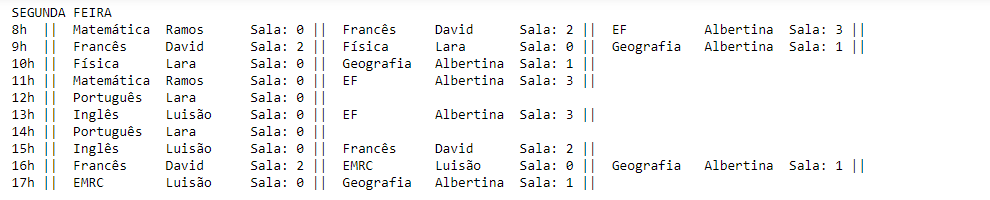

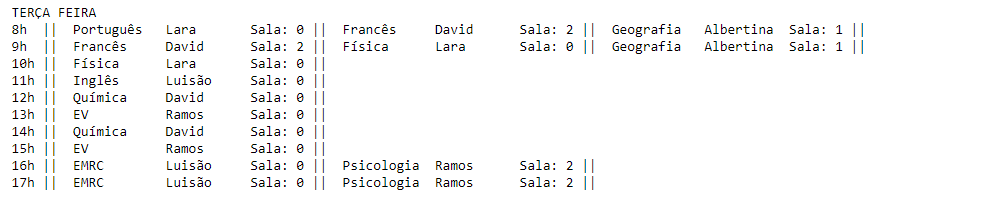

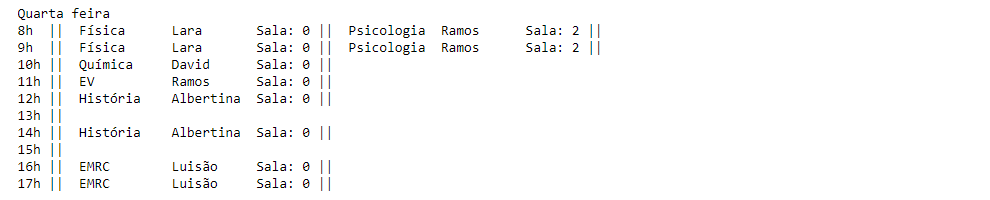

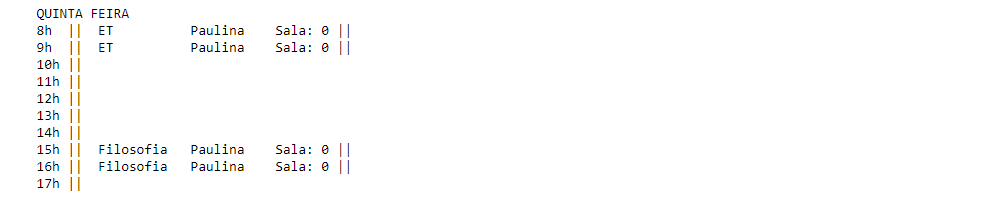

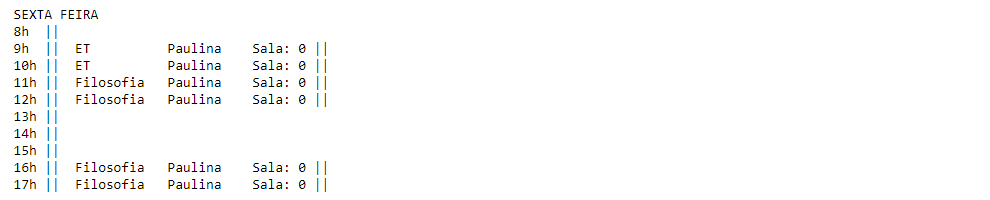

${\LARGE\text{Exemplo 2}}$

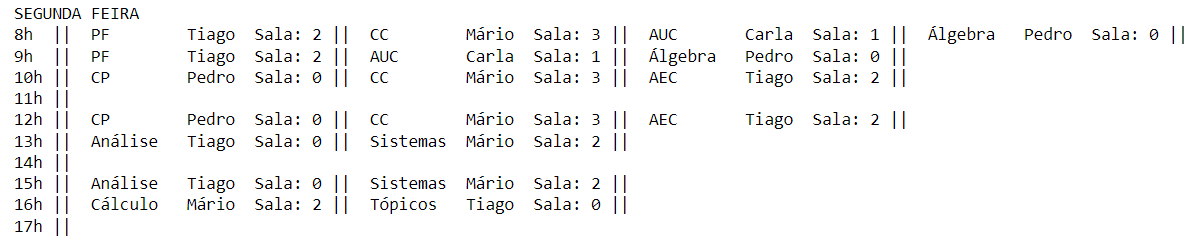

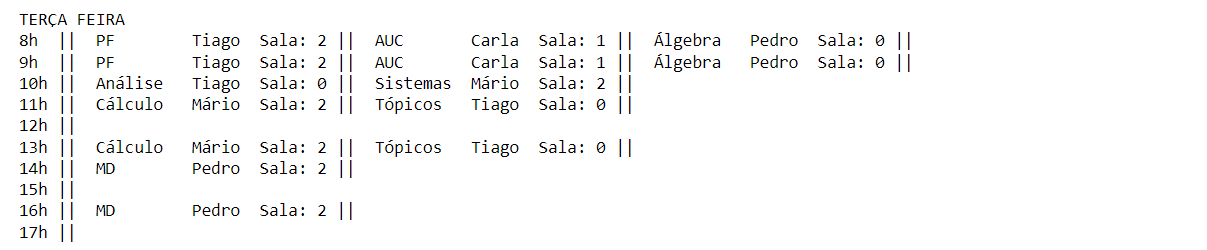

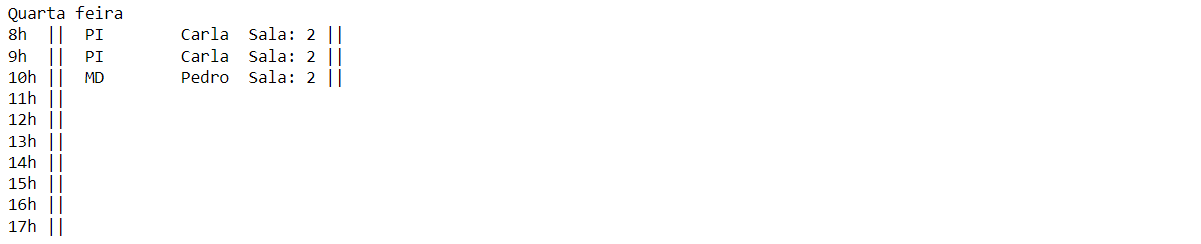

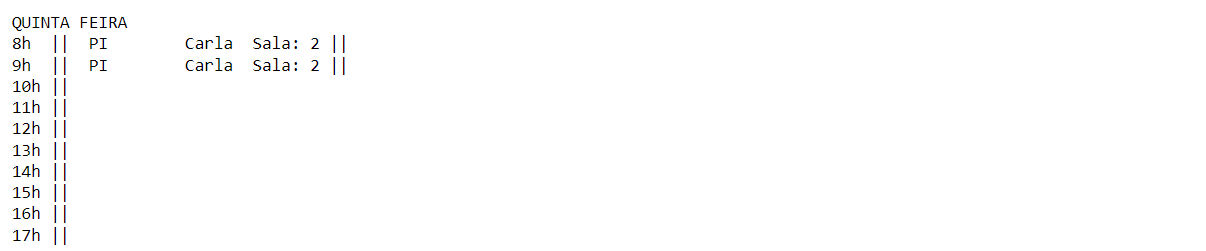

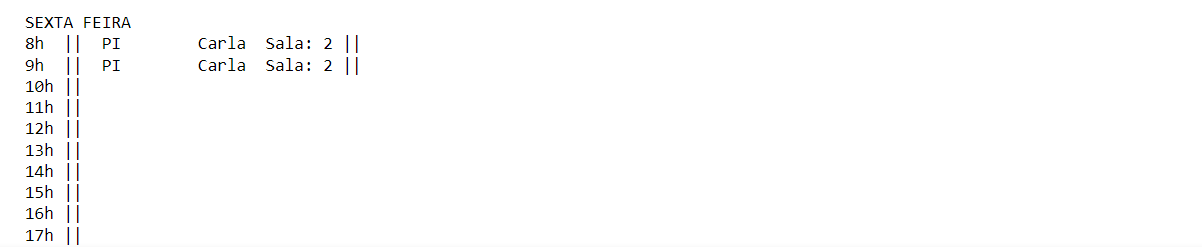